In [1]:
pacman::p_load(
  data.table,
  gsheet,
  janitor,
  dplyr,
  ggplot2,
  ggstance,
  fractional,
  RColorBrewer,
  stringr,
  limma
)

In [2]:
theme_set(theme_classic(base_size = 18) %+replace% theme(
  strip.background = element_blank(),
  # axis.line.y = element_line(colour = "black", size = 0.2),
  # axis.line.x = element_line(colour = "black", size = 0.2),
  axis.ticks   = element_line(colour = "black", size = 0.3),
  panel.border = element_rect(size = 0.3, fill = NA),
  axis.line    = element_blank(),
  plot.title   = element_text(size = 18, vjust = 2, hjust = 0.5),
  panel.grid.major = element_line(size = 0.2)
))

In [3]:
setwd("~/work/fibroblast_timecourse")
source("R/002_helper_functions.R")

In [4]:
qpcr_colors = list(
  cell_line = c(
    'RA1357'   = '#1B9E77',
    'RA160425' = '#E6AB02',
    'RA355'    = '#7570B3',
    'RA3916'   = '#E7298A'
  ),
  stimulation = c(
    "None" = "grey50",
    "TNF (0.1ng/mL)" = "#FEB24C",
    "TNF (0.1ng/mL)+IL-17 (1ng/mL)" = "#E31A1C"
  )
)

In [8]:
homer <- readr::read_tsv("pval	logpval	percent_targets	percent_background	std_bg_std	best_match	targets	consensus
1.00E-12	-2.81E+01	16.00%	0.00%	41.0bp (20.8bp)	NFkB-p65-Rel(RHD)/ThioMac-LPS-Expression(GSE23622)	CXCL6,CXCL3,CXCL2,CXCL1	CAGGGAATTTCC
1.00E-10	-2.44E+01	16.00%	0.02%	46.0bp (62.7bp)	CUX1/MA0754.1/Jaspar	CXCL3,CXCL2,PIM2,CXCL1	TCCGGATCGATC
1.00E-10	-2.31E+01	16.00%	0.02%	64.4bp (86.4bp)	Nur77(NR)/K562-NR4A1-ChIP-Seq(GSE31363)	TNFSF13B,CSF2,MMP3,CCL20	ACCTTYMCAWKA
1.00E-09	-2.30E+01	20.00%	0.11%	110.7bp (62.5bp)	REL/MA0101.1/Jaspar	PTGS2,NFKBIZ,CXCL3,CXCL2,CXCL1	TCCGGGSTTTCC
1.00E-09	-2.28E+01	16.00%	0.03%	88.8bp (94.7bp)	GLI2/MA0734.1/Jaspar	IL4I1,G0S2,C15orf48,CD83	GACCGCGCTGGC
1.00E-08	-1.95E+01	24.00%	0.52%	53.8bp (103.1bp)	Hic1/MA0739.1/Jaspar	NFKBIZ,G0S2,CXCL3,CXCL2,C15orf48,CXCL1,CCL20	GCGATGGCCC
1.00E-07	-1.74E+01	12.00%	0.02%	39.6bp (100.7bp)	EWSR1-FLI1/MA0149.1/Jaspar	CXCL3,CXCL2,CXCL1	GAAGGAAGGCGA
1.00E-06	-1.50E+01	20.00%	0.57%	54.8bp (118.2bp)	JUND/MA0491.1/Jaspar	NFKBIZ,CCL7,CSF2,MMP3,IL11	GACTCATCCT")

homer <- clean_names(homer)
homer$targets <- unname(sapply(homer$targets, function(x) paste(sort(str_split(x, ",")[[1]]), collapse = ",")))
homer

pval,logpval,percent_targets,percent_background,std_bg_std,best_match,targets,consensus
1e-12,-28.1,16.00%,0.00%,41.0bp (20.8bp),NFkB-p65-Rel(RHD)/ThioMac-LPS-Expression(GSE23622),"CXCL1,CXCL2,CXCL3,CXCL6",CAGGGAATTTCC
1e-10,-24.4,16.00%,0.02%,46.0bp (62.7bp),CUX1/MA0754.1/Jaspar,"CXCL1,CXCL2,CXCL3,PIM2",TCCGGATCGATC
1e-10,-23.1,16.00%,0.02%,64.4bp (86.4bp),Nur77(NR)/K562-NR4A1-ChIP-Seq(GSE31363),"CCL20,CSF2,MMP3,TNFSF13B",ACCTTYMCAWKA
1e-09,-23.0,20.00%,0.11%,110.7bp (62.5bp),REL/MA0101.1/Jaspar,"CXCL1,CXCL2,CXCL3,NFKBIZ,PTGS2",TCCGGGSTTTCC
1e-09,-22.8,16.00%,0.03%,88.8bp (94.7bp),GLI2/MA0734.1/Jaspar,"C15orf48,CD83,G0S2,IL4I1",GACCGCGCTGGC
1e-08,-19.5,24.00%,0.52%,53.8bp (103.1bp),Hic1/MA0739.1/Jaspar,"C15orf48,CCL20,CXCL1,CXCL2,CXCL3,G0S2,NFKBIZ",GCGATGGCCC
1e-07,-17.4,12.00%,0.02%,39.6bp (100.7bp),EWSR1-FLI1/MA0149.1/Jaspar,"CXCL1,CXCL2,CXCL3",GAAGGAAGGCGA
1e-06,-15.0,20.00%,0.57%,54.8bp (118.2bp),JUND/MA0491.1/Jaspar,"CCL7,CSF2,IL11,MMP3,NFKBIZ",GACTCATCCT


In [9]:
homer$log10p <- -log10(exp(homer$logpval))

In [13]:
xx <- str_replace(homer$best_match, "/Jaspar", "")
xx[1] <- 'NFkB-p65-REL'
xx[3] <- 'NUR77'
xx[7] <- "EWSR1"
xx[6] <- "HIC1"
xx <- str_split_fixed(xx, "/", 2)[,1]
homer$best_match <- xx
xx

[1] "NFkB-p65-REL" "CUX1"         "NUR77"        "REL"          "GLI2"        
[6] "HIC1"         "EWSR1"        "JUND"

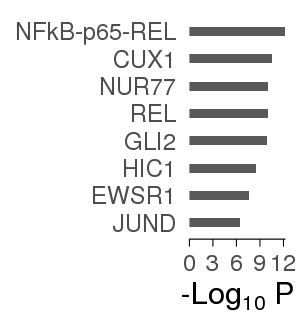

In [15]:
options(repr.plot.width = 2.5, repr.plot.height = 2.75)

p <- ggplot(homer, aes(y = reorder(best_match, log10p), x = log10p)) +
geom_colh(width = 0.33) +
labs(x = bquote("-Log"[10]~"P"), y = NULL, title = ) +
scale_x_continuous(labels = function(x) sprintf("%.0f", x), expand = c(0, 0)) +
theme(
  panel.grid = element_line(color = NA),
  panel.border = element_blank(),
  axis.line.x = element_line(),
  axis.ticks.y = element_blank()
)
                   
show_plot(p)#, res = 300)